In [1]:
import json
prettyprint = lambda x: json.dumps(x, indent=4, sort_keys=True)

## Exploring the data first

In [2]:
#This assumes you have all_plans_with_wires.json in the same folder as the notebook.
with open('all_plans_with_wires.json', 'r') as f:
    aq_plans_json = json.load(f)

In [3]:
print(len(aq_plans_json)) #9616
print(prettyprint(aq_plans_json[9615]))

9616
{
    "created_at": "2019-05-23T16:45:31.000-07:00",
    "id": 33674,
    "operations": [
        {
            "created_at": "2019-05-23T16:47:56.000-07:00",
            "field_values": [
                {
                    "rid": 6753363,
                    "role": "input",
                    "sample": {
                        "rid": 6753367,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753364,
                    "role": "input",
                    "sample": {
                        "rid": 6753369,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753365,
                    "role": "output",
                    "sample": {
                        "rid": 6753371,
                        "sample_type_id": 5
                    },
   

In [4]:
from pandas.io.json import json_normalize
operations_df = json_normalize(aq_plans_json, 
                       record_path='operations', 
                       meta=['id', 'status'],
                       record_prefix='op.')

/Users/danyfu/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/danyfu/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
print(operations_df['id'].nunique()) #should be 9616, not sure how we lost 14 plans

9602


In [6]:
operations_df.head(5)

,op.created_at,op.field_values,op.id,op.operation_type,op.operation_type_id,op.rid,op.status,op.updated_at,op.user_id,id,status
0,2017-07-13T08:29:06.000-07:00,"[{'rid': 19237, 'role': 'output', 'sample': {'...",17,Cloning,48,19235,done,2017-07-13T08:50:43.000-07:00,66,9,None
1,2017-07-13T08:29:06.000-07:00,"[{'rid': 19247, 'role': 'output', 'sample': {'...",18,Cloning,48,19245,done,2017-07-13T08:50:43.000-07:00,66,10,None
2,2017-07-13T08:58:15.000-07:00,"[{'rid': 19279, 'role': 'input', 'sample': {'r...",27,Cloning,20,19270,error,2017-07-13T09:17:41.000-07:00,17,13,None
3,2017-07-13T08:58:15.000-07:00,"[{'rid': 19292, 'role': 'input', 'sample': {'r...",28,Cloning,19,19271,error,2017-07-13T09:17:41.000-07:00,17,13,None
4,2017-07-13T08:58:15.000-07:00,"[{'rid': 19304, 'role': 'input', 'sample': {'r...",29,Cloning,18,19272,error,2017-07-13T09:17:41.000-07:00,17,13,None


In [7]:
operations_df = operations_df.drop(columns=['op.created_at', 'op.field_values', 'op.rid', 'op.status', 'op.updated_at']) # drop irrelevant columns
operations_df = operations_df.rename(index=str, columns={"op.operation_type": "op.category"}) #rename for clarity
print(operations_df['id'].nunique())
operations_df.head(5)

9602


,op.id,op.category,op.operation_type_id,op.user_id,id,status
0,17,Cloning,48,66,9,None
1,18,Cloning,48,66,10,None
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None


## Filter plans by status

In [8]:
# All possible plan statuses 
print(operations_df['status'].unique()) # [None, 'planning', 'template', 'system_template']

# Find "real" plans by filtering out any plans that are "planning" or templates
real_operations_df = operations_df.loc[operations_df['status'].isnull()]
print(real_operations_df['id'].nunique()) #8343

[None 'template' 'planning' 'system_template']
8343


## Analyze "islands" (plans with one operation)

In [9]:
op_counts_df = real_operations_df.groupby('id')['op.operation_type_id'].nunique().reset_index()
island_list = op_counts_df.loc[op_counts_df['op.operation_type_id'] == 1]['id'] #the op id here is actually a count
islands = real_operations_df[real_operations_df.id.isin(list(island_list))]['op.operation_type_id'].unique()
print(len(islands))
print(islands)

171
[ 48  22  18  19  33  24  17  38  31  21  34  25  23  58  28  42  64  65
  20  59  41  91 146  87 178  29  37  92 145 179  83  90  55 172 174  30
 186  82 197 203 204 195 208  49 196 213 219  89  74  75 137 222 223  73
 224 220 200  85  77  71  76 283 279 278 289 344  72 323  84 290 332 355
 212 337 228 259 284 258 262 362 361 371 379 266 272 375 381 393 394 392
 395 267 397 273  88 406 408 410 414 384 427 428 271 430 441 407 440 445
 443 444 401 447 446 331 442 412 376 453 274 275 199 452 374 456 459 462
 467 365 466 373 363 479 455 454 482 485 486 496 490 519 494 524 329  86
  78 565 566 545 571 548 575 562 265 596 506 606 607 399 609 605 264 534
 584 366 637 411 610 515 503 640 638]


In [10]:
# This is a list of all operation types in Aquarium
with open('aquarium-operations.json', 'r') as f:
    aq_ops = json.load(f)

print(prettyprint(aq_ops[0]))

{
    "category": "Cloning",
    "created_at": "2017-07-12T19:25:38.000-07:00",
    "deployed": true,
    "field_types": [
        {
            "allowable_field_types": [
                {
                    "created_at": "2017-07-12T19:25:38.000-07:00",
                    "field_type_id": 84,
                    "id": 64,
                    "object_type": {
                        "cleanup": "No cleanup information",
                        "columns": 12,
                        "cost": 1.0,
                        "created_at": "2014-08-28T17:19:55.000-07:00",
                        "data": "  {\r\n    \"materials\": 10.48,\r\n    \"labor\": 10\r\n  }",
                        "description": "Stripwell",
                        "handler": "collection",
                        "id": 440,
                        "image": "",
                        "max": 10000,
                        "min": 0,
                        "name": "Stripwell",
                        "prefix": "",
   

In [11]:
import pandas as pd
op_types_df = pd.DataFrame.from_dict(aq_ops)
op_types_df.head(5)

,category,created_at,deployed,field_types,id,name,on_the_fly,rid,updated_at
0,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,15,Run Gel,False,425,2017-07-12T19:26:14.000-07:00
1,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,16,Extract Gel Slice,False,426,2017-07-12T19:26:35.000-07:00
2,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,17,Pour Gel,True,427,2017-07-12T19:26:29.000-07:00
3,Cloning,2017-07-12T19:25:38.000-07:00,False,[{'allowable_field_types': [{'created_at': '20...,18,Send to Sequencing (old),False,428,2017-09-07T12:31:04.000-07:00
4,Cloning,2017-07-12T19:25:38.000-07:00,False,[{'allowable_field_types': [{'created_at': '20...,19,Upload Sequencing Results (old-old),False,429,2017-09-20T21:39:23.000-07:00


In [12]:
island_names = op_types_df[op_types_df['id'].isin(islands)]['name']
island_names

2                                 Pour Gel
3                 Send to Sequencing (old)
4      Upload Sequencing Results (old-old)
5            Make Glycerol Stock (old-old)
6                             Order Primer
                      ...                 
383                         Sample Factory
384                             Make Media
405        Purification Buffer Preparation
406               Lysis Buffer Preparation
408                     Make IPTG Aliquots
Name: name, Length: 171, dtype: object

## Filter islands

In [13]:
real_operations_without_islands_df = real_operations_df[~real_operations_df.id.isin(list(island_list))]
NUM_REAL_PLANS = real_operations_without_islands_df['id'].nunique() #5,969 plans
NUM_REAL_PLANS

5969

In [14]:
# get some basic stats of the final dataset we're working with
ops_per_plan = real_operations_without_islands_df.groupby("id")['op.id'].nunique()
print("mean:", ops_per_plan.mean()) #~14
print("standard dev:", ops_per_plan.std()) #~27
print("max:", ops_per_plan.max()) #643
print("id of plan with most operations:", ops_per_plan.idxmax()) #id of the plan with the most operations
print("min:", ops_per_plan.min()) #2
print("mode:", ops_per_plan.mode()) #3

mean: 14.235047746691238
standard dev: 27.039897131187086
max: 643
id of plan with most operations: 30442
min: 2
mode: 0    3
dtype: int64


## Split up large plans so we get a more reasonable standard deviation

In [15]:
# get all plans with more than 14 operations
op_count_df = ops_per_plan.reset_index().rename({'op.id': 'op_count'}, axis=1)
plans_more_than_14 = op_count_df.loc[op_count_df.op_count > 14]
print(plans_more_than_14.shape)
plans_more_than_14.head(5)

(1373, 2)


,id,op_count
39,439,15
107,810,18
108,820,18
131,971,16
215,1486,19


In [16]:
# inner join on the ~1300 plans
all_ops_more_than_14 = plans_more_than_14.merge(real_operations_without_islands_df, on='id', how='inner')
all_ops_more_than_14.head(5)

,id,op_count,op.id,op.category,op.operation_type_id,op.user_id,status
0,439,15,1131,Cloning,24,13,None
1,439,15,1132,Cloning,24,13,None
2,439,15,1133,Cloning,24,13,None
3,439,15,1134,Cloning,16,13,None
4,439,15,1135,Cloning,15,13,None


In [17]:
more_than_14_df = all_ops_more_than_14.groupby('id')['op.operation_type_id'].apply(list).reset_index()
more_than_14_df.head(5)

,id,op.operation_type_id
0,439,"[24, 24, 24, 16, 15, 17, 23, 16, 15, 17, 23, 1..."
1,810,"[28, 27, 26, 25, 24, 16, 15, 23, 24, 16, 15, 2..."
2,820,"[28, 27, 26, 25, 24, 16, 15, 17, 23, 22, 22, 2..."
3,971,"[19, 19, 19, 19, 18, 30, 29, 18, 30, 29, 18, 3..."
4,1486,"[20, 19, 18, 30, 29, 28, 27, 26, 25, 24, 16, 1..."


In [18]:
max_id = operations_df.id.max()
print(max_id)

33674


In [19]:
all_plan_ops_df = real_operations_without_islands_df.groupby('id')['op.operation_type_id'].apply(list).reset_index()
print(all_plan_ops_df.shape)
all_plan_ops_df.head(5)

(5969, 2)


,id,op.operation_type_id
0,13,"[20, 19, 18, 30, 29, 28]"
1,15,"[20, 19, 18, 30, 29, 28]"
2,17,"[20, 19, 18, 30, 29, 28]"
3,18,"[20, 19, 18, 30, 29, 28]"
4,20,"[20, 19, 18, 30, 29, 28]"


In [20]:
import numpy

full_ops_df = all_plan_ops_df

print('all plans:', full_ops_df.shape)
print('plans with more than 14 ops:', more_than_14_df.shape)

for index, row in more_than_14_df.iterrows():
    ops_in_plan = row['op.operation_type_id']
    for op_array in numpy.array_split(numpy.array(ops_in_plan), len(ops_in_plan)/14):
        max_id = full_ops_df.id.max() + 1
        full_ops_df = full_ops_df.append(pd.DataFrame({"id": max_id, "op.operation_type_id": [op_array]}))
    
    # drop the original row
    full_ops_df = full_ops_df[full_ops_df.id != row.id]

print('number of plans after split:', full_ops_df.shape)
full_ops_df.head(5)

all plans: (5969, 2)
plans with more than 14 ops: (1373, 2)
number of plans after split: (8004, 2)


,id,op.operation_type_id
0,13,"[20, 19, 18, 30, 29, 28]"
1,15,"[20, 19, 18, 30, 29, 28]"
2,17,"[20, 19, 18, 30, 29, 28]"
3,18,"[20, 19, 18, 30, 29, 28]"
4,20,"[20, 19, 18, 30, 29, 28]"


In [21]:
full_ops_df.loc[full_ops_df.id == 13]

,id,op.operation_type_id
0,13,"[20, 19, 18, 30, 29, 28]"


In [22]:
# something is wrong with explode, don't run this
exploded_df = full_ops_df.explode('op.operation_type_id')

In [23]:
exploded_df.loc[exploded_df.id == 13]

,id,op.operation_type_id
0,13,20
0,13,19
0,13,18
0,13,30
0,13,29
...,...,...
0,13,262
0,13,30
0,13,29
0,13,30


## Connected Components Approach

In [24]:
import networkx as nx
from itertools import chain

# Add every unique operation as a node to a networkx graph
G = nx.Graph()   
nodes = full_ops_df['op.operation_type_id']
result = set(chain(*nodes))
print(len(result))
G.add_nodes_from(result)

294


In [25]:
'''create a wires dataframe'''
from pandas.io.json import json_normalize
wires_df = json_normalize(aq_plans_json, record_path=['wires'])
wires_df = wires_df.drop(columns=['id', 'rid', 'sample']) # drop irrelevant columns
wires_df = wires_df.rename(index=str, columns={"from": "src_op_id", "to": "dest_op_id"}) #rename for clarity
wires_df.head(5)

,src_op_id,dest_op_id
0,28.0,27.0
1,29.0,28.0
2,28.0,27.0
3,30.0,29.0
4,29.0,28.0


In [26]:
import numpy as np
'''format the wires dataframe to get rid of undefined values'''
to_from_pairs_df = wires_df.drop_duplicates(subset=['src_op_id', 'dest_op_id']) #89459
to_from_pairs_df = to_from_pairs_df[~to_from_pairs_df.isin([np.nan, np.inf, -np.inf]).any(1)]
# fill in NaNs and cast from float to int
# to_from_pairs_df = to_from_pairs_df.fillna(value={'src_op_id': 0, 'dest_op_id': 0}) 
to_from_pairs_df = to_from_pairs_df.astype({"src_op_id": int, "dest_op_id": int})
# len(to_from_pairs)

In [50]:
'''left merge with destination to find op type'''
merged_to = wires_df.merge(real_operations_without_islands_df, left_on='dest_op_id', right_on='op.id', how='left')
merged_pairs_df = merged_to[['src_op_id', 'dest_op_id', 'op.operation_type_id']].reset_index()
merged_pairs_df = merged_pairs_df.rename(index=str, columns={"op.operation_type_id": "dest_op_type_id"}) #rename for clarity
merged_pairs_df.head(5)

,index,src_op_id,dest_op_id,dest_op_type_id
0,0,28.0,27.0,20.0
1,1,29.0,28.0,19.0
2,2,28.0,27.0,20.0
3,3,30.0,29.0,18.0
4,4,29.0,28.0,19.0


In [51]:
'''left merge with source to find op type'''
edge_pairs_df = merged_pairs_df.merge(real_operations_without_islands_df, left_on='src_op_id', right_on='op.id', how='left')
edge_pairs_df = edge_pairs_df[['src_op_id', 'dest_op_id', 'op.operation_type_id', 'dest_op_type_id', 'id']].reset_index()
edge_pairs_df = edge_pairs_df.rename(index=str, columns={"op.operation_type_id": "src_op_type_id", 'id': 'plan_id'}) #rename for clarity
edge_pairs_df.head(5)

,index,src_op_id,dest_op_id,src_op_type_id,dest_op_type_id,plan_id
0,0,28.0,27.0,19.0,20.0,13
1,1,29.0,28.0,18.0,19.0,13
2,2,28.0,27.0,19.0,20.0,13
3,3,30.0,29.0,30.0,18.0,13
4,4,29.0,28.0,18.0,19.0,13


In [53]:
edge_pairs_df.shape

(182113, 6)

In [69]:
pair_counts = edge_pairs_df.groupby(['src_op_type_id', 'dest_op_type_id']).size().reset_index()
weighted_edges = list(pair_counts.itertuples(index=False, name=None))
weighted_edges

[(15.0, 16.0, 5300),
 (16.0, 24.0, 5074),
 (16.0, 329.0, 28),
 (17.0, 15.0, 5334),
 (17.0, 538.0, 2),
 (18.0, 19.0, 228),
 (18.0, 20.0, 2),
 (19.0, 20.0, 92),
 (19.0, 38.0, 2),
 (20.0, 38.0, 2),
 (21.0, 22.0, 4288),
 (22.0, 18.0, 24),
 (22.0, 23.0, 1804),
 (22.0, 63.0, 44),
 (22.0, 84.0, 404),
 (22.0, 220.0, 68),
 (22.0, 270.0, 44),
 (22.0, 452.0, 12),
 (22.0, 467.0, 6),
 (22.0, 496.0, 2),
 (22.0, 534.0, 916),
 (23.0, 15.0, 2896),
 (23.0, 403.0, 42),
 (24.0, 23.0, 18),
 (24.0, 25.0, 1674),
 (24.0, 31.0, 14),
 (24.0, 84.0, 210),
 (24.0, 89.0, 12),
 (24.0, 198.0, 12),
 (24.0, 199.0, 22),
 (24.0, 275.0, 2),
 (24.0, 406.0, 116),
 (24.0, 411.0, 28),
 (24.0, 453.0, 2),
 (24.0, 455.0, 14),
 (24.0, 467.0, 4),
 (24.0, 496.0, 10),
 (24.0, 505.0, 28),
 (24.0, 529.0, 2),
 (24.0, 534.0, 54),
 (24.0, 548.0, 8),
 (24.0, 597.0, 64),
 (25.0, 23.0, 28),
 (25.0, 25.0, 6),
 (25.0, 26.0, 3362),
 (26.0, 27.0, 4076),
 (26.0, 627.0, 34),
 (27.0, 28.0, 4244),
 (28.0, 29.0, 4010),
 (28.0, 82.0, 54),
 (28.0, 449

In [71]:
G.add_weighted_edges_from(weighted_edges)

# Find the connected components in our graph. 
# The connected components would not be connected amongst each other, which can serve as a basis for getting the disjoint subsets.
print(len(sorted(nx.connected_components(G)))) # 41 components
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)] #number of operation types per component

41


[214,
 16,
 10,
 5,
 4,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [72]:
def get_component_percentage(component, dataframe):
    count = 0
    for index, row in dataframe.iterrows():
        #Check if first op belong to this group, add to count
        if row['op.operation_type_id'][0] in component:
            count+=1
            
    #return a percentage of plans
    return count/full_ops_df.shape[0]

for component in sorted(nx.connected_components(G), key=len, reverse=True):
    print(get_component_percentage(component, full_ops_df))

0.9502748625687156
0.006371814092953523
0.0012493753123438282
0.006621689155422289
0.0004997501249375312
0.0008745627186406797
0.0001249375312343828
0.0036231884057971015
0.0001249375312343828
0.01911544227886057
0.0001249375312343828
0.0
0.0
0.0002498750624687656
0.0016241879060469764
0.0022488755622188904
0.0008745627186406797
0.0006246876561719141
0.0
0.0
0.0003748125937031484
0.0001249375312343828
0.0001249375312343828
0.0
0.0
0.0024987506246876563
0.0007496251874062968
0.0
0.0
0.0001249375312343828
0.0
0.0003748125937031484
0.0001249375312343828
0.0003748125937031484
0.0
0.0001249375312343828
0.0002498750624687656
0.0001249375312343828
0.0
0.0
0.0


## Try to break down the biggest component

In [71]:
list_of_component_sets = sorted(nx.connected_components(G), key=len, reverse=True)
biggest_component_nodes = list(list_of_component_sets[0])
len(biggest_component_nodes)
H = G.subgraph(biggest_component_nodes)
H.edges()

EdgeView([(512, 503), (512, 426), (512, 405), (512, 511), (512, 512), (512, 504), (512, 408), (512, 514), (512, 516), (512, 581), (514, 504), (514, 408), (514, 516), (514, 581), (514, 514), (514, 405), (514, 585), (514, 586), (514, 426), (515, 376), (515, 440), (515, 266), (515, 262), (515, 415), (515, 270), (515, 271), (515, 269), (515, 377), (515, 378), (515, 380), (515, 267), (515, 275), (515, 274), (515, 654), (515, 652), (515, 653), (516, 504), (516, 408), (516, 581), (516, 516), (516, 405), (516, 585), (516, 586), (516, 426), (518, 452), (518, 518), (518, 24), (518, 16), (518, 15), (518, 17), (518, 23), (518, 26), (518, 22), (518, 21), (525, 262), (525, 267), (525, 495), (525, 483), (525, 496), (525, 494), (525, 90), (525, 440), (525, 259), (525, 258), (525, 272), (525, 266), (525, 525), (15, 25), (15, 24), (15, 16), (15, 17), (15, 23), (15, 20), (15, 19), (15, 18), (15, 30), (15, 29), (15, 28), (15, 27), (15, 26), (15, 15), (15, 31), (15, 22), (15, 21), (15, 50), (15, 84), (15, 

In [72]:
edge_to_remove = nx.minimum_edge_cut(H)
edge_to_remove

{(610, 609)}

In [73]:
unfreezed_graph = nx.Graph(H)
unfreezed_graph.remove_edge(610,609)
nx.is_connected(unfreezed_graph)
[len(c) for c in sorted(nx.connected_components(unfreezed_graph), key=len, reverse=True)]

[238, 1]

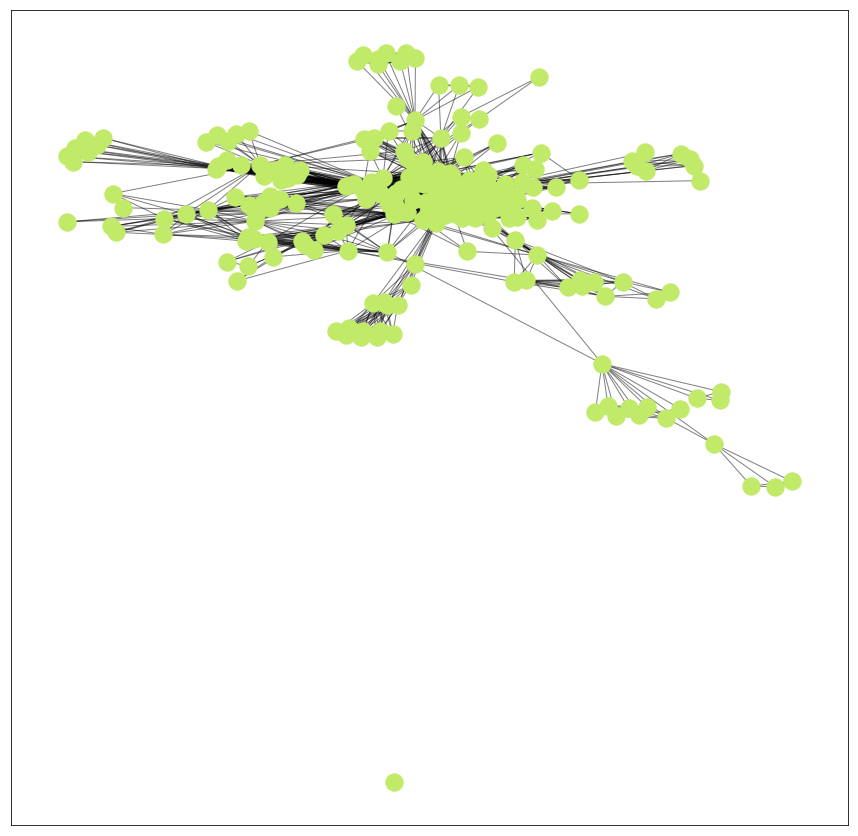

In [74]:
import matplotlib.pyplot as plt
import randomcolor

%matplotlib inline 
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

pos = nx.spring_layout(unfreezed_graph)
nx.draw_networkx_nodes(unfreezed_graph, pos, unfreezed_graph.nodes(),
                                node_color = randomcolor.RandomColor().generate()[0])
nx.draw_networkx_edges(unfreezed_graph, pos, alpha=0.5)

## Remove every node and see if our data gets split more evenly

In [75]:
def break_down_futher(temp_graph):
    for node in temp_graph:
        #make fresh copy of the graph
        G_temp = nx.Graph(temp_graph)
        #remove node from graph
        G_temp.remove_node(node)
        components= sorted(nx.connected_components(G_temp), key=len, reverse=True)
        #Now find connected components and print length of each
        print("The node and components are....")
        print(node)
        print([len(c) for c in components])

In [76]:
break_down_futher(unfreezed_graph)

The node and components are....
512
[237, 1]
The node and components are....
514
[237, 1]
The node and components are....
515
[237, 1]
The node and components are....
516
[237, 1]
The node and components are....
518
[237, 1]
The node and components are....
525
[237, 1]
The node and components are....
15
[237, 1]
The node and components are....
16
[237, 1]
The node and components are....
17
[237, 1]
The node and components are....
18
[237, 1]
The node and components are....
19
[237, 1]
The node and components are....
20
[237, 1]
The node and components are....
21
[237, 1]
The node and components are....
22
[237, 1]
The node and components are....
23
[237, 1]
The node and components are....
24
[237, 1]
The node and components are....
25
[237, 1]
The node and components are....
26
[237, 1]
The node and components are....
27
[237, 1]
The node and components are....
28
[237, 1]
The node and components are....
29
[237, 1]
The node and components are....
30
[237, 1]
The node and components ar

The node and components are....
426
[237, 1]
The node and components are....
440
[237, 1]
The node and components are....
441
[237, 1]
The node and components are....
442
[237, 1]
The node and components are....
443
[237, 1]
The node and components are....
444
[237, 1]
The node and components are....
445
[237, 1]
The node and components are....
446
[237, 1]
The node and components are....
447
[237, 1]
The node and components are....
449
[237, 1]
The node and components are....
450
[237, 1]
The node and components are....
451
[237, 1]
The node and components are....
452
[237, 1]
The node and components are....
453
[237, 1]
The node and components are....
454
[237, 1]
The node and components are....
455
[237, 1]
The node and components are....
459
[237, 1]
The node and components are....
460
[237, 1]
The node and components are....
461
[237, 1]
The node and components are....
462
[237, 1]
The node and components are....
464
[237, 1]
The node and components are....
466
[237, 1]
The node a

### Remove the node that is the most connected (178)

In [77]:
G_without_178 = unfreezed_graph
G_without_178.remove_node(178)

### Remove all plans that contains operation type 178

In [78]:
indexes_to_drop = full_ops_df[[(178 in ops) for ops in full_ops_df['op.operation_type_id']]].index
# To Check, use
# for index in indexes_to_drop:
#     print(df_no_178.loc[[index]])

df_no_178 = full_ops_df
df_no_178.drop(indexes_to_drop , inplace=True)
WITHOUT_178_PLANS_NUM = df_no_178.shape[0]

In [79]:
def get_component_percentage(component):
    count = 0
    for index, row in df_no_178.iterrows():
        #Check if first op belong to this group, add to count
        if row['op.operation_type_id'][0] in component:
            count+=1
            
    #return a percentage of plans
    return count/WITHOUT_178_PLANS_NUM

In [80]:
for component in sorted(nx.connected_components(G_without_178), key=len, reverse=True):
    print(get_component_percentage(component))

0.9580324909747292
0.002256317689530686
0.003835740072202166
0.0006768953068592057


# Old Code

In [43]:
islands= []
#each component is a set, do below to access the component
#ref: https://stackoverflow.com/questions/59825/how-to-retrieve-an-element-from-a-set-without-removing-it
[islands.append(c.pop()) for c in sorted(nx.connected_components(G), key=len, reverse=True)  if len(c) == 1]
islands

[519,
 524,
 48,
 565,
 566,
 55,
 59,
 571,
 64,
 65,
 575,
 72,
 76,
 85,
 92,
 606,
 607,
 638,
 640,
 146,
 186,
 197,
 204,
 208,
 228,
 283,
 323,
 337,
 355,
 373,
 379,
 584,
 392,
 397,
 427,
 428,
 456,
 479,
 485,
 486,
 605,
 506]

In [18]:
indexNames = df_plan_ops[[any(island in ops for island in islands) for ops in df_plan_ops['op.operation_type_id']]].index
print(len(indexNames))
# Delete these row indexes from dataFrame

891


### Hence, 891 plans belong to island related nodes. Let's remove those as they hold no contribution

In [19]:
#Biggest component contains 239 operations
df_plan_without_islands = df_plan_ops
df_plan_without_islands.drop(indexNames , inplace=True)

In [46]:
without_islands_df = real_operations_df[~real_operations_df['op.operation_type_id'].isin(islands)]
without_islands_list = without_islands_df.groupby('id')['op.operation_type_id'].unique()
without_islands = without_islands_list.to_frame().reset_index()
print(without_islands['id'].nunique())

7452


In [49]:
without_islands_df.head(5)

,op.id,op.category,op.operation_type_id,op.user_id,id,status
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None
5,30,Cloning,30,17,13,None
6,31,Cloning,29,17,13,None


In [51]:
ops_per_plan.head

<bound method NDFrame.head of id
13        6
15        6
17        6
18        6
20        6
27        6
29        6
31        6
33        6
38        9
39        9
40        3
42        7
44        7
46        4
48        4
50        7
52        1
55        1
56        1
58        1
60        1
63        6
68        6
70        6
72        6
74        6
76        6
113       4
114       4
         ..
33592     8
33595     3
33597     3
33599    12
33621    14
33622    32
33624    14
33633    24
33634    12
33641    12
33644    17
33648     5
33652    48
33653     5
33656    15
33657     6
33658     6
33661    51
33662     1
33663     2
33664     5
33665    60
33666     4
33667     6
33668     6
33669     5
33670     5
33671     1
33673     5
33674     5
Name: op.id, Length: 7452, dtype: int64>

In [20]:
G_no_islands = nx.Graph(G)

for island in islands:
    G_no_islands.remove_node(island)

len(G_no_islands.nodes)

294

In [218]:
[len(c) for c in sorted(nx.connected_components(G_no_islands), key=len, reverse=True)]

[239, 18, 11, 6, 4, 4, 3, 3, 2, 2, 2]

In [240]:
# out = pd.DataFrame(df_plan_ops['op.operation_type_id'].values.tolist())
# out.head()# op.operation_type_id
# out_178 = out.loc[out.eq(178).any(1)]
# out_178.head()

In [251]:
# Further break down the 238 component
biggest_component_222 = list(components_222[0])
len(biggest_component_222)
sub_222 = G.subgraph(biggest_component_222)
sub_222.edges()

EdgeView([(15, 25), (15, 24), (15, 16), (15, 17), (15, 23), (15, 20), (15, 19), (15, 18), (15, 30), (15, 29), (15, 28), (15, 27), (15, 26), (15, 31), (15, 22), (15, 21), (15, 50), (15, 84), (15, 83), (15, 82), (15, 88), (15, 87), (15, 89), (15, 213), (15, 214), (15, 215), (15, 220), (15, 63), (15, 47), (15, 221), (15, 198), (15, 199), (15, 534), (15, 43), (15, 454), (15, 455), (15, 90), (15, 266), (15, 262), (15, 267), (15, 275), (15, 271), (15, 270), (15, 269), (15, 274), (15, 264), (15, 265), (15, 466), (15, 468), (15, 406), (15, 494), (15, 496), (15, 493), (15, 56), (15, 57), (15, 58), (15, 499), (15, 500), (15, 453), (15, 449), (15, 450), (15, 452), (15, 518), (15, 495), (15, 545), (15, 529), (15, 403), (15, 329), (15, 86), (15, 78), (15, 399), (15, 400), (15, 402), (15, 407), (15, 398), (15, 548), (15, 597), (15, 596), (15, 80), (15, 410), (15, 258), (15, 272), (15, 277), (15, 276), (15, 273), (16, 25), (16, 24), (16, 17), (16, 23), (16, 20), (16, 19), (16, 18), (16, 30), (16, 29)

In [252]:
break_down_futher(sub_222)


The node and components are....
15
[221]
The node and components are....
16
[221]
The node and components are....
17
[221]
The node and components are....
18
[221]
The node and components are....
19
[221]
The node and components are....
20
[221]
The node and components are....
21
[221]
The node and components are....
22
[221]
The node and components are....
23
[221]
The node and components are....
24
[221]
The node and components are....
25
[221]
The node and components are....
26
[221]
The node and components are....
27
[221]
The node and components are....
28
[221]
The node and components are....
29
[221]
The node and components are....
30
[221]
The node and components are....
31
[221]
The node and components are....
33
[221]
The node and components are....
34
[221]
The node and components are....
35
[221]
The node and components are....
37
[221]
The node and components are....
38
[221]
The node and components are....
39
[221]
The node and components are....
40
[221]
The node and com

The node and components are....
618
[221]
The node and components are....
621
[221]
The node and components are....
622
[221]
The node and components are....
623
[221]
The node and components are....
624
[221]
The node and components are....
626
[221]
The node and components are....
627
[221]
The node and components are....
635
[221]
The node and components are....
641
[221]
The node and components are....
642
[221]
The node and components are....
643
[221]
The node and components are....
646
[221]
The node and components are....
648
[221]
The node and components are....
649
[221]
The node and components are....
652
[221]
The node and components are....
653
[221]
The node and components are....
654
[221]
The node and components are....
657
[221]
